In [1]:
# Import modules
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
stuffs = ["electron", "jet", "MET", "muon", "photon", "tau"]
data_variables = ["HT", "met", "phi_diff", "ptmax", "stuff_amount"]
file_amounts = [2, 18, 3]


def work_space(path):
    while True:
        if os.path.split(path)[1] != "Phys117":
            path = os.path.split(path)[0]
        else:
            return path.replace("\\", "/")

work_dir = work_space(os.getcwd())
data_path = work_dir + "/Markus/Hub/VariableData/"
folders = os.listdir(data_path)
data_files = [data_path + data_file for data_file in folders]


def remover(old_list, index):
    new_list = [element for element_index, element in enumerate(old_list) if element_index != index]
    return new_list


def list_unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == list:
            list_unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


def data_binner(data, binsize):
    data = list_unpacker(data, [])

    if len(data) == 0:
        x = [bin * binsize for bin in range(200)]
        y = [0 for bin in range(200)]
        return x, y

    max_value = np.max(data)
    bins = int(np.round(max_value / binsize))
    bins = np.arange(0, bins)
    data = np.array(data)
    x, y = [], []

    for bin in range(len(bins)):
        temp = data
        temp = temp[temp <= (bin + 1/2)*binsize]
        temp = temp[(bin - 1/2)*binsize < temp]
        if len(temp) != 0:
            y.append(len(temp))
            x.append(bin*binsize)

    y = y/np.sum(y)

    return x, y


def plot_filter(interval_data, filter_strength):
    interval_data = sorted(interval_data)
    cutoff = round((len(interval_data) * filter_strength))
    interval_data = interval_data[:cutoff]
    x_min = np.min(interval_data)
    x_max = np.max(interval_data)
    extra = (x_max - x_min) / 10
    return [x_min - extra, x_max + extra]


def dataframe_retriever(data_files, folders, filename_list):
    dataframes = [(pd.read_csv(data_file).drop("Unnamed: 0", axis = 1), filename) for data_file, filename in zip(list_unpacker(data_files, []), list_unpacker(filename_list, []))]
    return dataframes


def sampler(output_dataframe, output_filenames, file_amounts, combine_data):
    from random import sample

    output_dataframe = [[(dataframe, filename) for dataframe, filename in zip(dataframes, filenames)] for dataframes, filenames in zip(output_dataframe, output_filenames)]
    samples = [sample(dataframes, file_amount) for dataframes, file_amount in zip(output_dataframe, file_amounts)]

    if combine_data:
        output_dataframe = [pd.concat([sample[0] for sample in dataframes]) for dataframes in samples]
        labels = folders
    else:
        output_dataframe = [[sample[0] for sample in dataframes] for dataframes in samples]
        labels = [[sample[1] for sample in dataframes] for dataframes in samples]

    return output_dataframe, labels


def plotter(data_variables, output_dataframe, filter_strengths, binsizes):
    for variable_index, variable in enumerate(data_variables):
        fig = plt.figure(figsize = (12, 6))
        style = "seaborn-v0_8-darkgrid"
        plt.style.use(style)
        title = variable + " Distribution"
        fig.suptitle(title)
        plt.xlabel(variable)
        plt.ylabel("frequency")

        binsize = binsizes[variable_index] if type(binsizes) == list else binsizes
        filter_strength = filter_strengths[variable_index] if type(filter_strengths) == list else filter_strengths
        interval = np.concatenate([dataframe[0][variable] for dataframe in output_dataframe])
        plt.xlim(plot_filter(interval, filter_strength))

        for dataframe in output_dataframe:
            raw_data = dataframe[0][variable]
            label = dataframe[1]
            bins, counts = data_binner(raw_data, binsize)
            plt.plot(bins, counts, label = label)
        
        plt.legend(prop = {'size': 8})
    plt.show()
    plt.close()


In [2]:
from FilesFunc import files
folders = ["Background", "BH", "Sphaleron"]

data_path = work_dir + "/Markus/Hub/VariableData/"
data_folders = [data_path + folder for folder in os.listdir(data_path)]
data_files = [[data_folder + "/" + filename for filename in os.listdir(data_folder)] for data_folder in data_folders]

if "Background" in folders:
    remove_index = folders.index("Background")
    folders = remover(folders, remove_index)
    data_files = remover(data_files, remove_index)

filenames_path = work_dir + "/Data/Pandas/Individual/"
folder_list, filename_list = files(filenames_path, folders, file_amounts = [18, 3])
model_dataframes = dataframe_retriever(data_files, folders, filename_list)

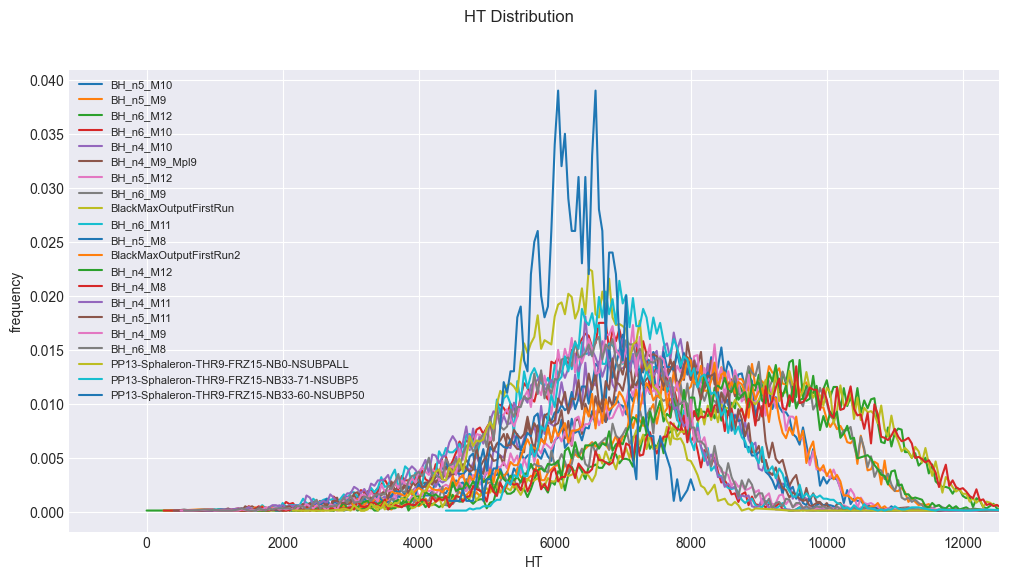

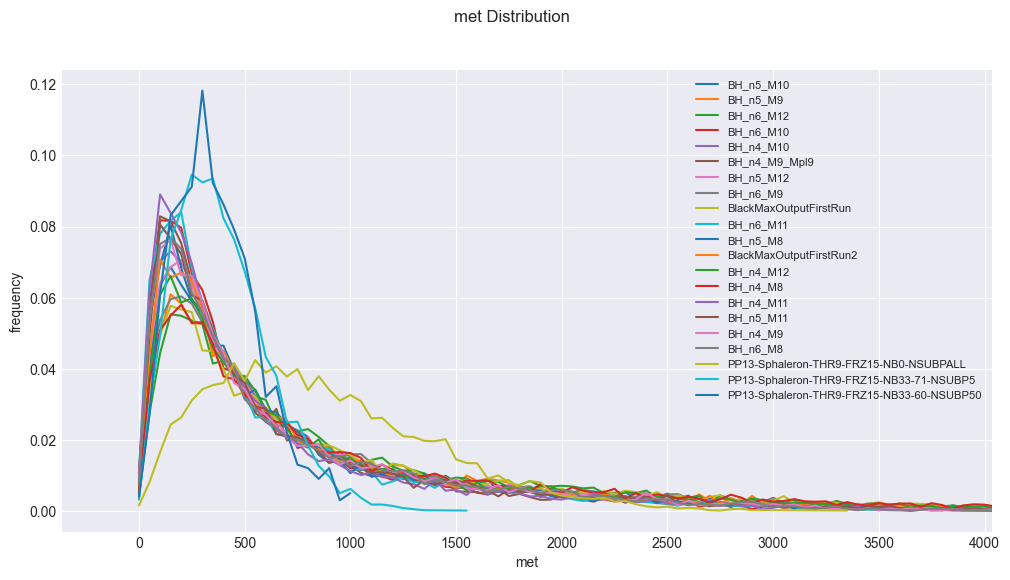

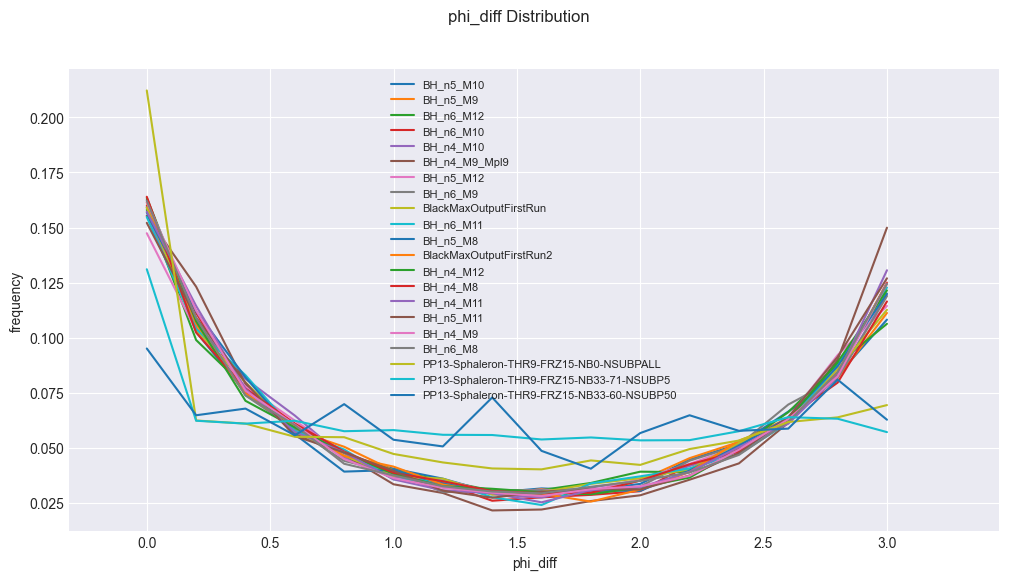

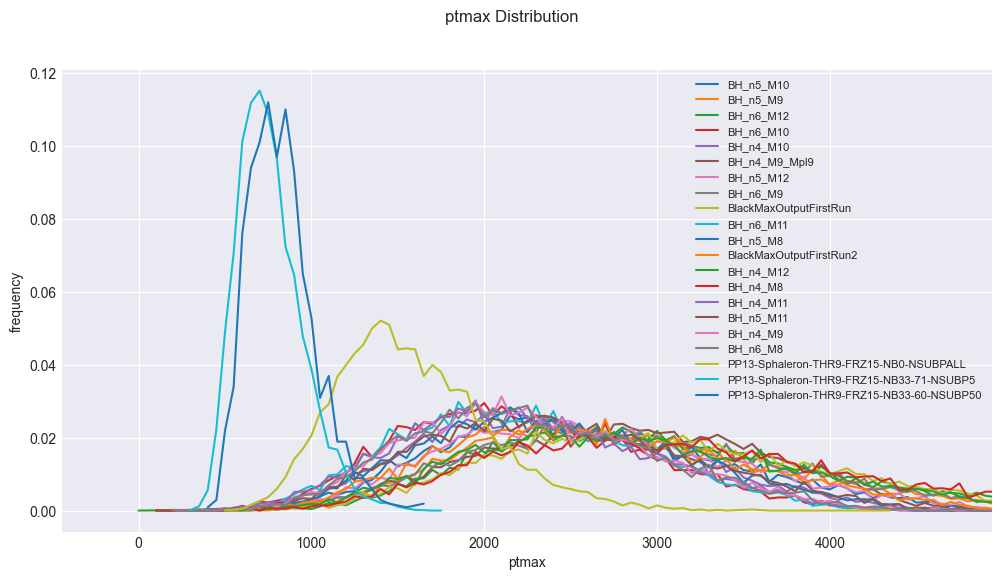

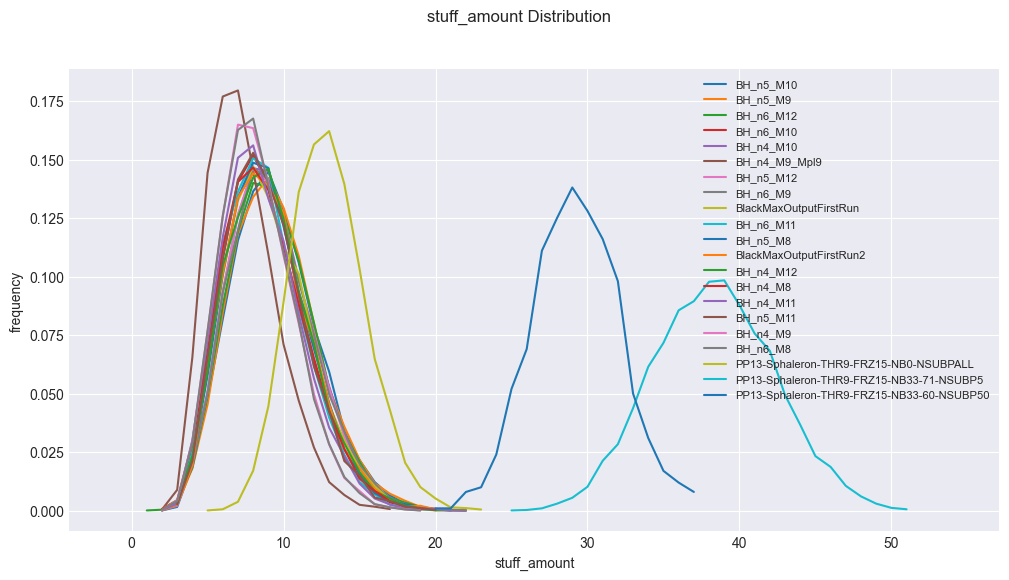

In [3]:
plotter(data_variables, model_dataframes, filter_strengths = [0.99, 0.99, 1, 0.975, 1], binsizes = [50, 50, 0.2, 50, 0.5])